In [1]:
import numpy as np
import simulator, grn
import matplotlib.pyplot as plt

# NPMP project 2: LSFR and random number generation

## Necessary component circuits for a LSFR:
- XOR gate
- D flip-flop


## XOR gate

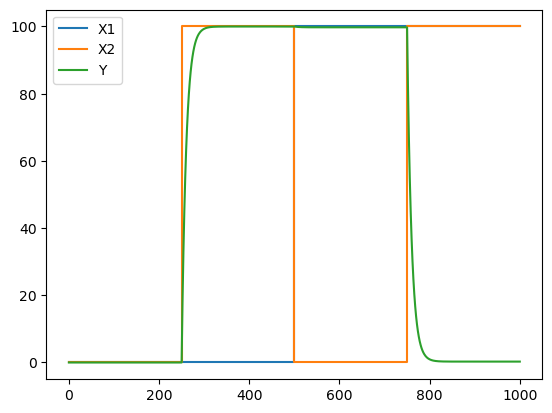

In [2]:
xor_grn = grn.grn()
xor_grn.add_input_species("X1")
xor_grn.add_input_species("X2")

xor_grn.add_species("Y", 0.1)

regulators = [{'name': 'X1', 'type': -1, 'Kd': 5, 'n': 2},
                {'name': 'X2', 'type': 1, 'Kd': 5, 'n': 3}]
products = [{'name': 'Y'}]
xor_grn.add_gene(10, regulators, products)

regulators = [{'name': 'X1', 'type': 1, 'Kd': 5, 'n': 2},
                {'name': 'X2', 'type': -1, 'Kd': 5, 'n': 3}]
products = [{'name': 'Y'}]
xor_grn.add_gene(10, regulators, products)

T, Y = simulator.simulate_sequence(xor_grn, [(0,0), (0,100), (100,0), (100,100)], t_single = 250)

## D flip-flop
We will build a D flip-flop progressively, starting from a rs flipflop, then a D latch, and finally a D flip-flop.

### RS flip-flop

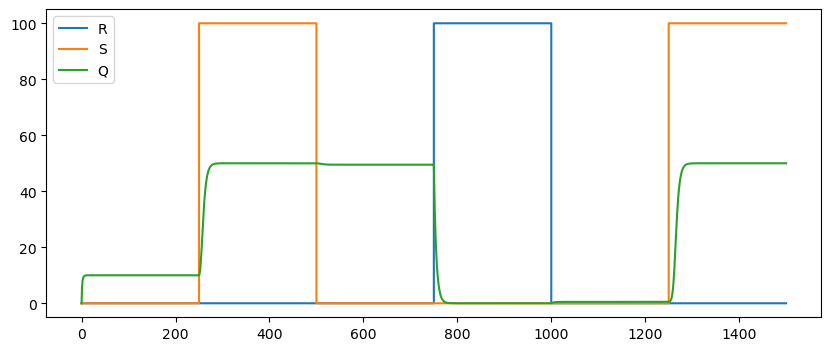

In [3]:
def add_rs_flip_flop(grn: grn.grn, r_name="R", s_name="S", q_name="Q", notQ_name="Q_", kd=5, n=2, delta=0.2, alpha=10):
    grn.add_species(q_name, delta)
    grn.add_species(notQ_name, delta)

    grn.add_gene(alpha, [{'name': r_name, 'type': -1, 'Kd': kd, 'n': n}, {'name': notQ_name, 'type': -1, 'Kd': kd, 'n': n}], [{'name': q_name}])
    grn.add_gene(alpha, [{'name': s_name, 'type': -1, 'Kd': kd, 'n': n}, {'name': q_name, 'type': -1, 'Kd': kd, 'n': n}], [{'name': notQ_name}])

rsff_grn = grn.grn()
rsff_grn.add_input_species("R")
rsff_grn.add_input_species("S")
add_rs_flip_flop(rsff_grn)


inputs = [(0, 0), (0, 100), (0, 0), (100, 0), (0, 0), (0, 100)]
plt.figure(figsize=(10, 4))
T, Y = simulator.simulate_sequence(rsff_grn, inputs, t_single = 250, displayed=['R','S','Q'])

## D-latch

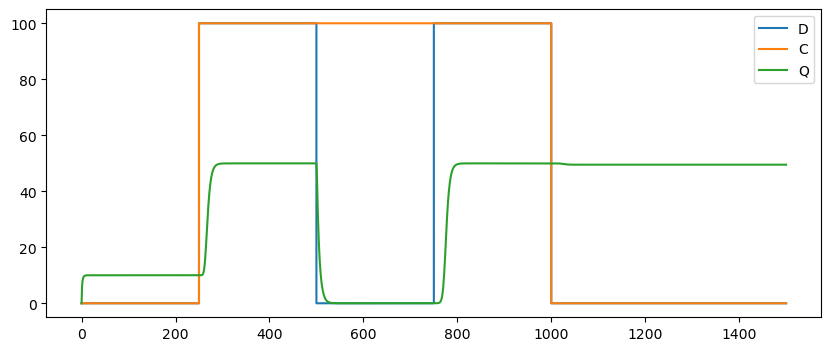

In [5]:
dlatch_grn = grn.grn()

dlatch_grn.add_input_species("D")
dlatch_grn.add_input_species("C")

dlatch_grn.add_species("notD", 0.2)
dlatch_grn.add_gene(10, [{'name': 'D', 'type': -1, 'Kd': 5, 'n': 2}], [{'name': 'notD'}])

dlatch_grn.add_species("notC", 0.2)
dlatch_grn.add_gene(10, [{'name': 'C', 'type': -1, 'Kd': 5, 'n': 2}], [{'name': 'notC'}])

# AND 1
dlatch_grn.add_species("DandC", 0.2)
dlatch_grn.add_gene(10, [{'name': 'notD', 'type': -1, 'Kd': 5, 'n': 2}, {'name': 'C', 'type': 1, 'Kd': 5, 'n': 2}], [{'name': 'DandC'}])

# AND 2
dlatch_grn.add_species("notDandC", 0.2)
dlatch_grn.add_gene(10, [{'name': 'D', 'type': -1, 'Kd': 5, 'n': 2}, {'name': 'C', 'type': 1, 'Kd': 5, 'n': 2}], [{'name': 'notDandC'}])

# RS FLIP-FLOP
add_rs_flip_flop(dlatch_grn, r_name="notDandC", s_name="DandC", q_name="Q", notQ_name="Q_", kd=5, n=2)

inputs = [(0, 0), (100, 100), (0, 100), (100, 100), (0,0), (0,0)]
plt.figure(figsize=(10, 4))
T, y = simulator.simulate_sequence(dlatch_grn, inputs, t_single = 250, plot_on=True, displayed=['D', 'C', 'Q'])


### D flipflop (falling edge triggered)

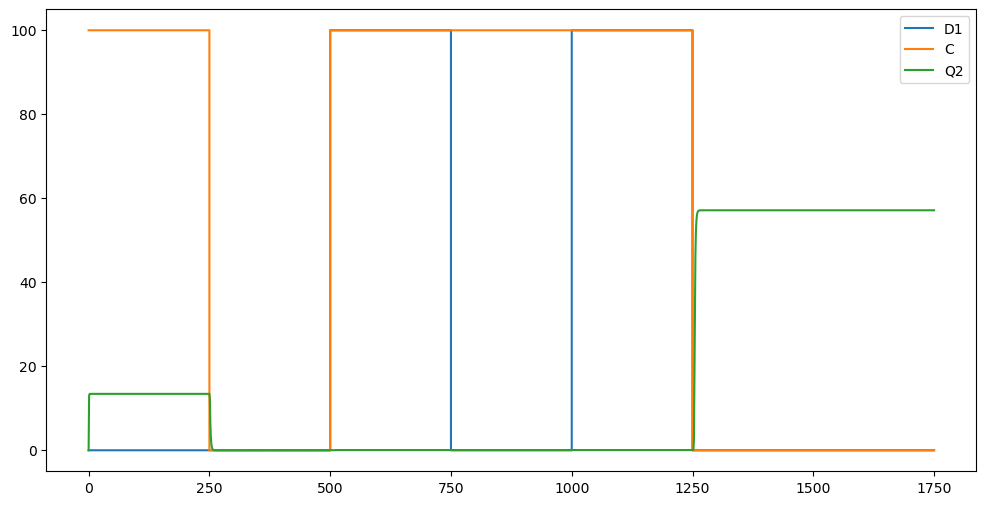

In [6]:
dff_grn = grn.grn()

alpha = 40
delta = 0.7
kd = 10
n = 4

# -FIRST D-LATCH
dff_grn.add_input_species("D1")
dff_grn.add_input_species("C")

dff_grn.add_species("notD1", delta)
dff_grn.add_gene(alpha, [{'name': 'D1', 'type': -1, 'Kd': kd, 'n': n}], [{'name': 'notD1'}])

dff_grn.add_species("notC", delta)
dff_grn.add_gene(alpha, [{'name': 'C', 'type': -1, 'Kd': kd, 'n': n}], [{'name': 'notC'}])

# AND 1.1
dff_grn.add_species("D1andC", delta)
dff_grn.add_gene(alpha, [{'name': 'notD1', 'type': -1, 'Kd': kd, 'n': n}, {'name': 'C', 'type': 1, 'Kd': kd, 'n': n}], [{'name': 'D1andC'}])

# AND 1.2
dff_grn.add_species("notD1andC", delta)
dff_grn.add_gene(alpha, [{'name': 'D1', 'type': -1, 'Kd': kd, 'n': n}, {'name': 'C', 'type': 1, 'Kd': kd, 'n': n}], [{'name': 'notD1andC'}])

# RS FLIP-FLOP 1
add_rs_flip_flop(dff_grn, r_name="notD1andC", s_name="D1andC", q_name="Q1", notQ_name="Q1_", kd=kd, n=n, delta=delta, alpha=alpha)

# - FOR second D-latch:
# D2 = Q1
# C2 = notC

dff_grn.add_species("D2", delta)
dff_grn.add_gene(alpha, [{'name': 'Q1', 'type': 1, 'Kd': kd, 'n': n}], [{'name': 'D2'}])

dff_grn.add_species("C2", delta)
dff_grn.add_gene(alpha, [{'name': 'notC', 'type': 1, 'Kd': kd, 'n': n}], [{'name': 'C2'}])

dff_grn.add_species("notD2", delta)
dff_grn.add_gene(alpha, [{'name': 'D2', 'type': -1, 'Kd': kd, 'n': n}], [{'name': 'notD2'}])

dff_grn.add_species("notC2", delta)
dff_grn.add_gene(alpha, [{'name': 'C2', 'type': -1, 'Kd': kd, 'n': n}], [{'name': 'notC2'}])

# AND 2.1
dff_grn.add_species("D2andC2", delta)
dff_grn.add_gene(alpha, [{'name': 'notD2', 'type': -1, 'Kd': kd, 'n': n}, {'name': 'C2', 'type': 1, 'Kd': kd, 'n': n}], [{'name': 'D2andC2'}])

# AND 2.2
dff_grn.add_species("notD2andC2", delta)
dff_grn.add_gene(alpha, [{'name': 'D2', 'type': -1, 'Kd': kd, 'n': n}, {'name': 'C2', 'type': 1, 'Kd': kd, 'n': n}], [{'name': 'notD2andC2'}])

# RS FLIP-FLOP 2
add_rs_flip_flop(dff_grn, r_name="notD2andC2", s_name="D2andC2", q_name="Q2", notQ_name="Q2_", kd=kd, n=n, delta=delta, alpha=alpha)


inputs = [(0,100),(0, 0), (100, 100), (0, 100), (100,100), (0,0), (0,0)]
plt.figure(figsize=(12, 6))
T, y = simulator.simulate_sequence(dff_grn, inputs, t_single = 250,displayed=['C', 'D1', 'Q2'])
